# 1.4d: Cluster Validation - Pairwise Cosines

This notebook validates that cluster tokens are truly indistinguishable by computing pairwise cosine similarities in bfloat16.

## The Question

We identified 2,251 tokens as "indistinguishable" based on having identical cosine (0.84375) to a reference direction.

But does identical cosine **to one direction** imply identical cosine **to all directions**?

If these tokens are truly indistinguishable by the model, their normalized bfloat16 embeddings should be identical (or very nearly so), which means **all pairwise cosines should equal 1.0**.

## Approach

1. Load cluster membership (2,251 tokens)
2. Extract cluster embeddings in bfloat16
3. Compute full pairwise cosine similarity matrix
4. Analyze distribution of cosine values
5. Check if all cosines = 1.0 (perfect indistinguishability)

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Cluster Membership

In [4]:
# Load cluster data
cluster_path = Path(f"../tensors/{MODEL_NAME}/1.4a_cluster_members.safetensors")
cluster_data = load_file(cluster_path)

cluster_token_ids = cluster_data["cluster_token_ids"].long()
n_cluster = cluster_data["n_cluster_members"].item()
cluster_cosine = cluster_data["cluster_cosine"].item()

print(f"Loaded cluster membership:")
print(f"  Cluster size: {n_cluster:,} tokens")
print(f"  Cluster cosine to reference: {cluster_cosine:.8f}")
print(f"  Token IDs (first 10): {cluster_token_ids[:10].tolist()}")

Loaded cluster membership:
  Cluster size: 2,251 tokens
  Cluster cosine to reference: 0.84375000
  Token IDs (first 10): [124, 125, 177, 178, 179, 180, 181, 182, 183, 184]


## Load Cluster Embeddings

In [5]:
# Load full W matrix
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(W_path)["W"]

print(f"\nLoaded W: {W_bf16.shape}")
print(f"  Dtype: {W_bf16.dtype}")

# Extract cluster embeddings
W_cluster_bf16 = W_bf16[cluster_token_ids]

print(f"\nExtracted cluster embeddings:")
print(f"  Shape: {W_cluster_bf16.shape}")
print(f"  ({n_cluster:,} tokens × 2,560 dimensions)")


Loaded W: torch.Size([151936, 2560])
  Dtype: torch.bfloat16

Extracted cluster embeddings:
  Shape: torch.Size([2251, 2560])
  (2,251 tokens × 2,560 dimensions)


## Compute Pairwise Cosines in Bfloat16

This is the key test: are all cluster tokens mutually indistinguishable?

In [6]:
print("\nComputing pairwise cosines in bfloat16...\n")

# Move to device and normalize
W_cluster_device = W_cluster_bf16.to(device)
W_cluster_norm = W_cluster_device / W_cluster_device.norm(dim=1, keepdim=True)

# Compute pairwise cosines
with torch.no_grad():
    cosines_bf16 = W_cluster_norm @ W_cluster_norm.T

# Move to CPU for analysis
cosines_bf16_cpu = cosines_bf16.cpu()

print(f"✓ Computed pairwise cosines")
print(f"  Matrix shape: {cosines_bf16_cpu.shape}")
print(f"  Total pairs: {(n_cluster * (n_cluster - 1)) // 2:,} (upper triangle, excluding diagonal)")

# Extract upper triangle (excluding diagonal)
triu_indices = torch.triu_indices(n_cluster, n_cluster, offset=1)
cosines_upper = cosines_bf16_cpu[triu_indices[0], triu_indices[1]]

print(f"\nCosine statistics (pairwise):")
print(f"  Min: {cosines_upper.min():.8f}")
print(f"  Max: {cosines_upper.max():.8f}")
print(f"  Mean: {cosines_upper.mean():.8f}")
print(f"  Median: {cosines_upper.median():.8f}")


Computing pairwise cosines in bfloat16...

✓ Computed pairwise cosines
  Matrix shape: torch.Size([2251, 2251])
  Total pairs: 2,532,375 (upper triangle, excluding diagonal)

Cosine statistics (pairwise):
  Min: 0.98437500
  Max: 1.00000000
  Mean: 1.00000000
  Median: 1.00000000


## Analyze Unique Cosine Values

In [7]:
print("\nAnalyzing unique cosine values...\n")

unique_cosines, counts = torch.unique(cosines_upper, return_counts=True)
n_unique = unique_cosines.numel()

print(f"Unique cosine values: {n_unique:,}")
print()

# Check for perfect similarity (cosine = 1.0)
n_perfect = (cosines_upper == 1.0).sum().item()
n_near_perfect = (cosines_upper >= 0.9999).sum().item()

print(f"Perfect similarity (cosine = 1.0): {n_perfect:,} pairs ({n_perfect/len(cosines_upper)*100:.2f}%)")
print(f"Near-perfect (cosine ≥ 0.9999): {n_near_perfect:,} pairs ({n_near_perfect/len(cosines_upper)*100:.2f}%)")
print()

# Show distribution of unique values
sorted_indices = torch.argsort(counts, descending=True)
top_n = min(20, n_unique)

print(f"Top {top_n} most common cosine values:")
for i in range(top_n):
    idx = sorted_indices[i]
    cosine_val = unique_cosines[idx].item()
    count = counts[idx].item()
    print(f"  {i+1}. cosine={cosine_val:.8f}: {count:,} pairs")


Analyzing unique cosine values...

Unique cosine values: 5

Perfect similarity (cosine = 1.0): 2,469,809 pairs (97.53%)
Near-perfect (cosine ≥ 0.9999): 2,469,809 pairs (97.53%)

Top 5 most common cosine values:
  1. cosine=1.00000000: 2,469,809 pairs
  2. cosine=0.99609375: 46,766 pairs
  3. cosine=0.99218750: 11,282 pairs
  4. cosine=0.98828125: 4,506 pairs
  5. cosine=0.98437500: 12 pairs


## Histogram of Pairwise Cosines


Creating histogram...



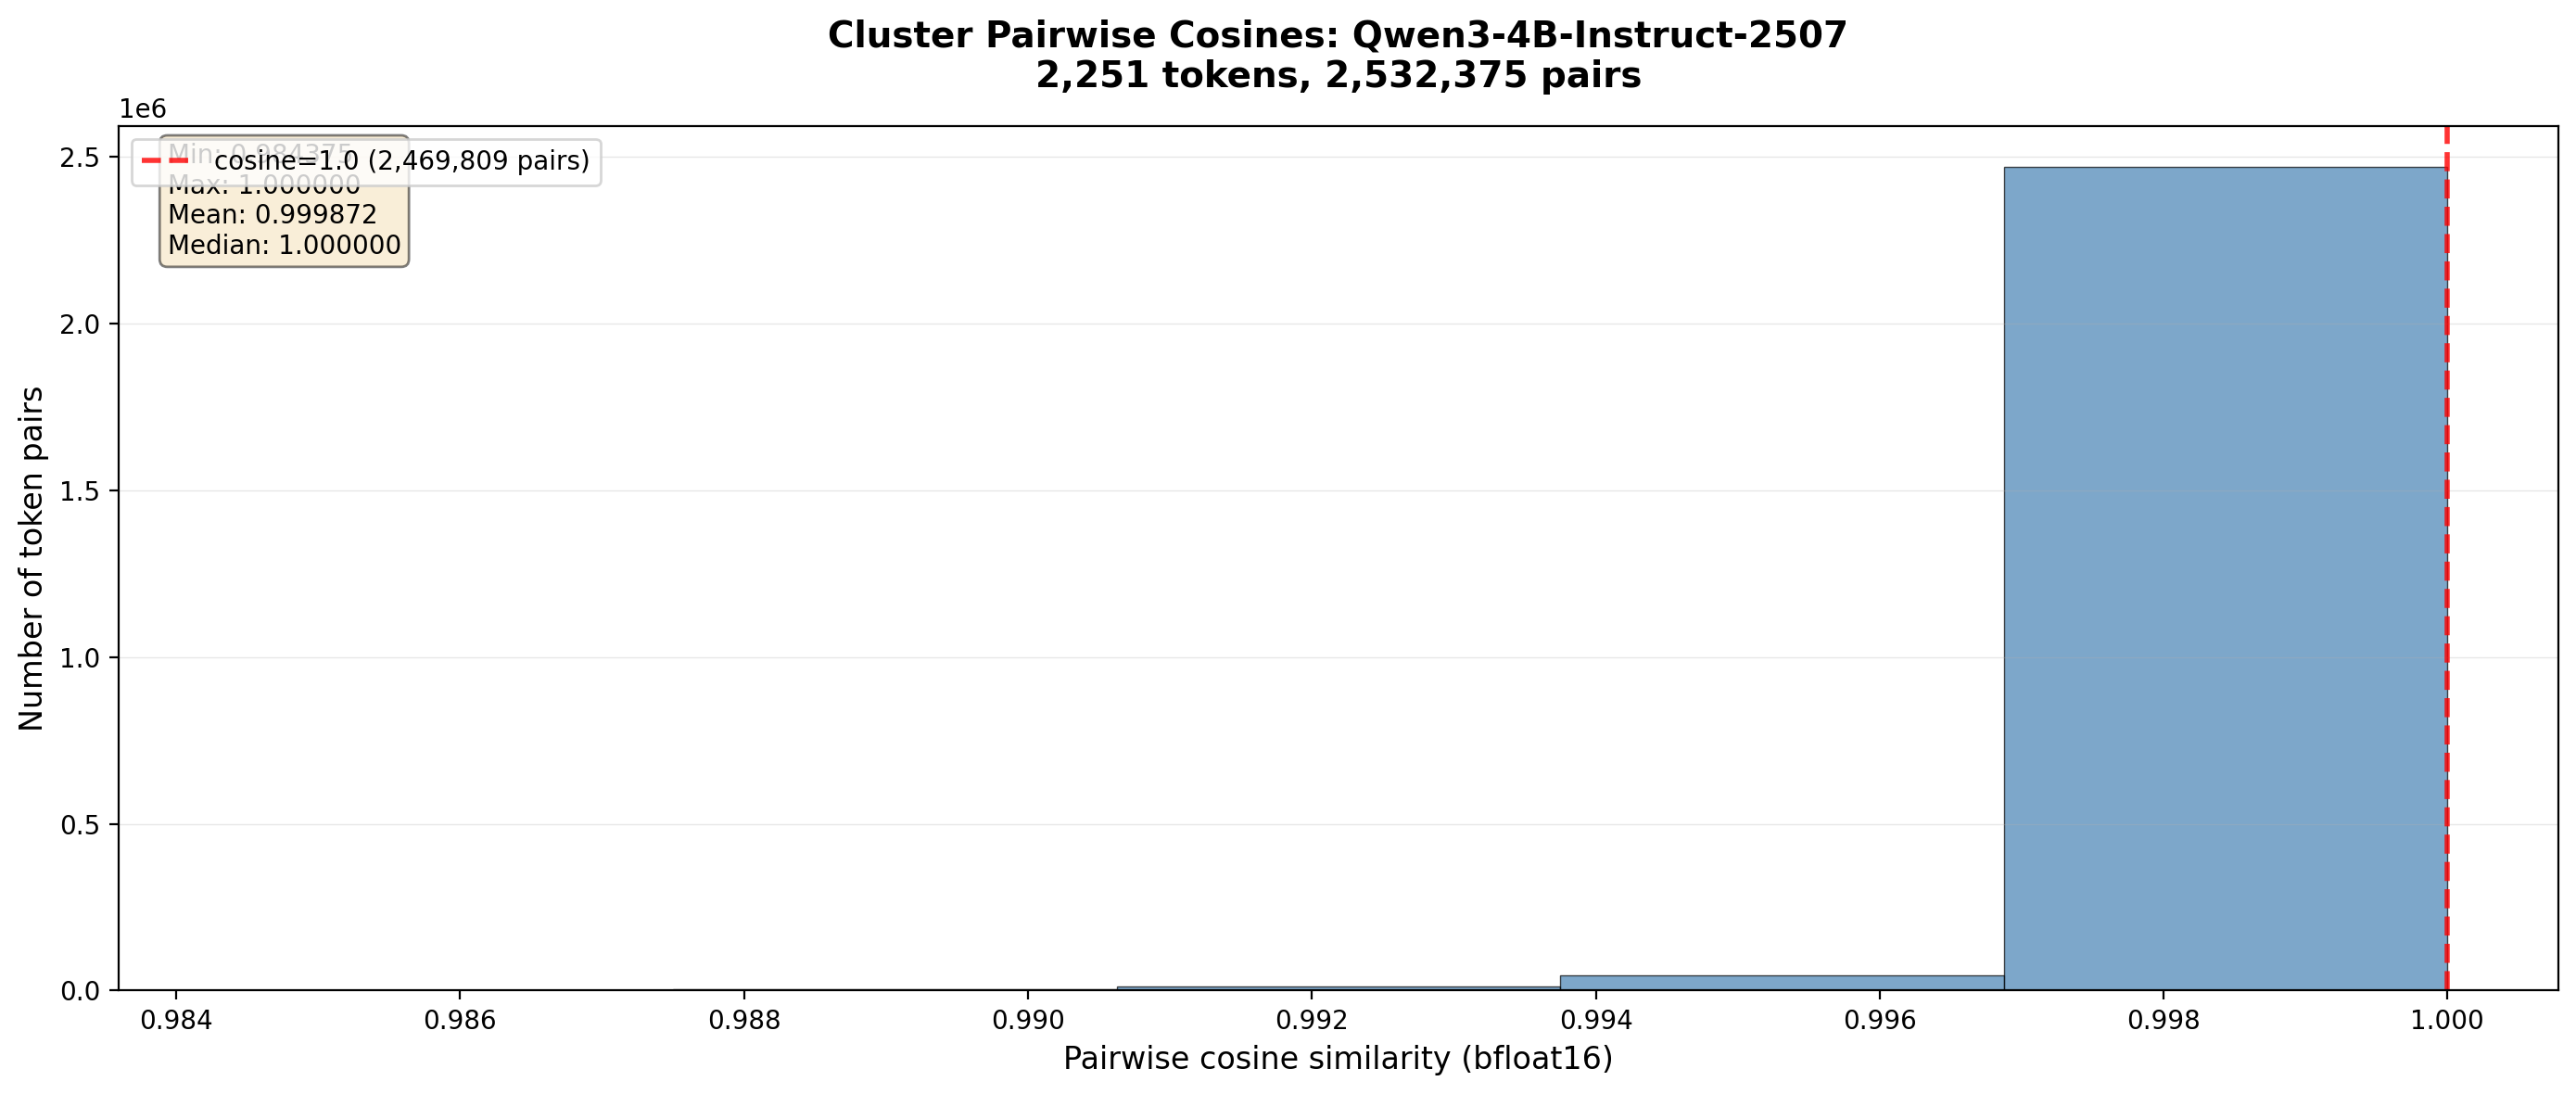

✓ Histogram complete


In [8]:
print("\nCreating histogram...\n")

# Convert to numpy (via float32 since numpy doesn't support bfloat16)
cosines_np = cosines_upper.to(torch.float32).numpy()

# Create figure
fig, ax = plt.subplots(figsize=(14, 6), dpi=200)

# Plot histogram
n_bins = min(100, n_unique)
counts_hist, bins, patches = ax.hist(cosines_np, bins=n_bins, 
                                      color='steelblue', alpha=0.7, 
                                      edgecolor='black', linewidth=0.5)

# Highlight cosine = 1.0
if n_perfect > 0:
    ax.axvline(1.0, color='red', linestyle='--', linewidth=2,
               label=f'cosine=1.0 ({n_perfect:,} pairs)', alpha=0.8)

# Formatting
ax.set_xlabel('Pairwise cosine similarity (bfloat16)', fontsize=12)
ax.set_ylabel('Number of token pairs', fontsize=12)
ax.set_title(f'Cluster Pairwise Cosines: {MODEL_NAME}\n{n_cluster:,} tokens, '
             f'{len(cosines_upper):,} pairs',
             fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linewidth=0.5, axis='y')
if n_perfect > 0:
    ax.legend(loc='upper left', fontsize=10)

# Add statistics box
stats_text = (f"Min: {cosines_np.min():.6f}\n"
              f"Max: {cosines_np.max():.6f}\n"
              f"Mean: {cosines_np.mean():.6f}\n"
              f"Median: {np.median(cosines_np):.6f}")
ax.text(0.02, 0.98, stats_text,
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("✓ Histogram complete")

## Interpretation

**If all pairwise cosines = 1.0:**
- Cluster tokens have **identical normalized embeddings** in bfloat16
- They are truly **mutually indistinguishable** from any direction
- The cluster is a **true equivalence class**

**If pairwise cosines < 1.0:**
- Cluster tokens have **different embeddings** (different magnitudes or directions)
- They are only indistinguishable **from the reference direction**
- They lie on the same ray from origin but at different radii, or in a cone around the reference
- We've caught tokens that "look the same" from one angle but differ from other viewpoints